In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tonic

# Modular way

## Functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tonic
import warnings
# train linear classifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning


def check_data(data_folder, chars, fidxs):
    """
    print the number of particles with more than 1000 frames in each file. 
    use this to check the class and trial imbalance of the dataset.
    """
    per_particle = {ch: (0, 0) for ch in chars}
    for ch in chars:
        for fi in fidxs:
            path = os.path.join(data_folder, f'{ch}{fi}.npy')
            data = np.load(path, allow_pickle=True)
            n_over1k = len([e for e in data if e.shape[0] >= 1000])
            per_particle[ch] = (
                per_particle[ch][0] + n_over1k, per_particle[ch][1] + data.shape[0])
            print(f'{ch}{fi}: {n_over1k/1e3:4.1f}k ({n_over1k/data.shape[0]:5.1%})', end=', ')
        print()
    for ch, (n_over, n_total) in per_particle.items():
        print(f'{ch}: {n_over/1000:5.1f}k ({n_over/n_total:5.1%})')


def load_data(data_folder, chars, fidxs, flatten=True):
    """
    load data and transform it to images
    """
    data = []
    label = []
    trial = []
    for class_idx, ch in enumerate(chars):
        for fi in fidxs:
            path = f'{data_folder}/{ch}{fi}.npy'
            d = np.load(path, allow_pickle=True)
            d = d[[e.shape[0] >= 1_000 for e in d]]
            data.append(d)
            label.append([class_idx] * len(d))
            trial.append([fi] * len(d))
    data = np.concatenate(data)
    label = np.concatenate(label)
    trial = np.concatenate(trial)

    # transform data
    transform = tonic.transforms.ToImage(sensor_size=(32, 24, 2,))
    data = np.array([transform(img) for img in data])
    if flatten:
        # 2, 24, 32 -> 1536
        data = data.reshape(data.shape[0], -1) 
    return data, label, trial


def train_linear_each_trial(data_folder, chars, fidxs, silent=True):
    # load data
    print('loading data...', end='\r')
    data, label, trial = load_data(data_folder, chars, fidxs, flatten=True)
    print('loaded data:', data.shape)

    # train linear regression
    pipelines = []
    tracc = []
    teacc = []
    cfms = []
    for test_trial in range(1, 5):
        # train test split
        train_idxs = trial != test_trial
        test_idxs = trial == test_trial
        train_data = data[train_idxs]
        train_labels = label[train_idxs]
        test_data = data[test_idxs]
        test_labels = label[test_idxs]
        # train_trials = trial[train_idxs]
        # test_trials = trial[test_idxs]

        # log
        print(f'Testing on trial {test_trial}, training on all others')
        print(f'  Train: {train_data.shape[0]/1000:3.0f}k, Test: {test_data.shape[0]/1000:3.0f}k')

        # train pipeline: standard scaler + logistic regression
        pipeline = Pipeline([
            ('scaler', StandardScaler()), 
            ('model', LogisticRegression(max_iter=1000))
        ])
        if silent:
            warnings.simplefilter('ignore', ConvergenceWarning)
        pipeline.fit(train_data, train_labels)
        warnings.simplefilter('default', ConvergenceWarning)

        pipelines.append(pipeline)
        tracc.append(pipeline.score(train_data, train_labels))
        teacc.append(pipeline.score(test_data, test_labels))
        cfms.append((
            confusion_matrix(pipeline.predict(train_data), train_labels, normalize='true'),
            confusion_matrix(pipeline.predict(test_data), test_labels, normalize='true')
        ))
        print(f'Train accuracy: {tracc[-1]:.2%}')
        print(f'Test accuracy:  {teacc[-1]:.2%}')
        print()
    tracc = np.array(tracc)
    teacc = np.array(teacc)
    print(f'training: {tracc.mean():.2%} +- {tracc.std():.2%}')
    print(f'testing:  {teacc.mean():.2%} +- {teacc.std():.2%}')
    return pipelines, tracc, teacc, cfms


def train_linear_all_trials(data_folder, chars, fidxs, train_split=0.8, silent=True):
    transform = tonic.transforms.ToImage(sensor_size=(32, 24, 2,))
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []
    train_trials = []
    test_trials = []
    for class_idx, ch in enumerate(chars):
        for fi in fidxs:
            path = f'{data_folder}/{ch}{fi}.npy'
            d = np.load(path, allow_pickle=True)
            # filter (>1k events), transform to image, flatten
            d = d[[e.shape[0] >= 1_000 for e in d]]
            d = np.array([transform(img) for img in d]).reshape(-1, 1536)

            # random 80/20 split
            train_len = int(d.shape[0] * train_split)
            test_len = d.shape[0] - train_len
            shuffled_idxs = np.random.permutation(d.shape[0])
            train_data.append(d[shuffled_idxs[:train_len]])
            test_data.append(d[shuffled_idxs[train_len:]])

            train_labels += [class_idx] * train_len
            test_labels += [class_idx] * test_len
            train_trials += [fi] * train_len
            test_trials += [fi] * test_len
    train_data = np.concatenate(train_data)
    test_data = np.concatenate(test_data)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    train_trials = np.array(train_trials)
    test_trials = np.array(test_trials)

    # train pipeline: standard scaler + logistic regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', LogisticRegression(max_iter=1500))
    ])

    if silent:
        warnings.simplefilter('ignore', ConvergenceWarning)
    pipeline.fit(train_data, train_labels)
    warnings.simplefilter('default', ConvergenceWarning)

    tracc = pipeline.score(train_data, train_labels)
    print(f'Train accuracy: {tracc:.2%}')

    print(f'Test accuracy: ', end='')
    teacc = {}
    cfms = []
    for te_idx in range(1, 5):
        te_mask = test_trials == te_idx
        teacc[te_idx] = pipeline.score(test_data[te_mask], test_labels[te_mask])
        print(f'{teacc[te_idx]:.2%}', end=' ')
    print()

    print(f'on all testing data: {pipeline.score(test_data, test_labels):.2%}')

    return pipeline, tracc, teacc, cfms


## Initialize

In [3]:
DATA_FOLDER = '../data/quat_1ms_comp'
CHARS = list("ABCD")
FIDXS = list(range(1, 5))

In [4]:
def check_data(data_folder, chars, fidxs):
    """
    print the number of particles with more than 1000 frames in each file. 
    use this to check the class and trial imbalance of the dataset.
    """
    per_particle = {ch: (0, 0) for ch in chars}
    per_trial = {fi: (0, 0) for fi in fidxs}
    for ch in chars:
        for fi in fidxs:
            path = os.path.join(data_folder, f'{ch}{fi}.npy')
            data = np.load(path, allow_pickle=True)
            n_over1k = len([e for e in data if e.shape[0] >= 1000])
            per_particle[ch] = (
                per_particle[ch][0] + n_over1k, per_particle[ch][1] + data.shape[0])
            per_trial[fi] = (
                per_trial[fi][0] + n_over1k, per_trial[fi][1] + data.shape[0])
            print(f'{ch}{fi}: {n_over1k/1e3:4.1f}k ({n_over1k/data.shape[0]:5.1%})', end=', ')
        print()
    for ch, (n_over, n_total) in per_particle.items():
        print(f'{ch}: {n_over/1000:5.1f}k ({n_over/n_total:5.1%})')
    for fi, (n_over, n_total) in per_trial.items():
        print(f'{fi}: {n_over/1000:5.1f}k ({n_over/n_total:5.1%})')

In [5]:
check_data(DATA_FOLDER, CHARS, FIDXS)

A1:  0.7k ( 1.1%), A2:  3.7k ( 6.5%), A3:  2.6k ( 4.2%), A4: 13.5k (22.8%), 
B1:  1.5k ( 2.6%), B2:  2.4k ( 4.3%), B3:  2.1k ( 3.6%), B4:  3.9k ( 6.6%), 
C1: 22.3k (38.8%), C2: 20.2k (36.2%), C3:  0.0k ( 0.0%), C4:  0.0k ( 0.1%), 
D1: 11.6k (20.6%), D2:  0.7k ( 1.1%), D3:  0.8k ( 1.4%), D4:  0.2k ( 0.4%), 
A:  20.4k ( 8.7%)
B:  10.0k ( 4.3%)
C:  42.5k (18.3%)
D:  13.3k ( 5.6%)
1:  36.0k (15.6%)
2:  26.9k (11.7%)
3:   5.5k ( 2.3%)
4:  17.7k ( 7.5%)


## training on each different trial split

In [ ]:
pipelines, tracc, teacc, cfms = train_linear_each_trial(DATA_FOLDER, CHARS, FIDXS, silent=True)

loaded data: (86220, 1536)
Testing on trial 1, training on all others
  Train:  50k, Test:  36k
Train accuracy: 99.53%
Test accuracy:  92.59%

Testing on trial 2, training on all others
  Train:  59k, Test:  27k
Train accuracy: 99.51%
Test accuracy:  97.95%

Testing on trial 3, training on all others
  Train:  81k, Test:   6k
Train accuracy: 99.73%
Test accuracy:  87.23%

Testing on trial 4, training on all others
  Train:  69k, Test:  18k
Train accuracy: 99.71%
Test accuracy:  83.60%

training: 99.62% +- 0.10%
testing:  90.34% +- 5.43%


## Confusion matrix

/tmp/ipykernel_7107/4208051002.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(range(5))
/tmp/ipykernel_7107/4208051002.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(range(5))
/tmp/ipykernel_7107/4208051002.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(CHARS)


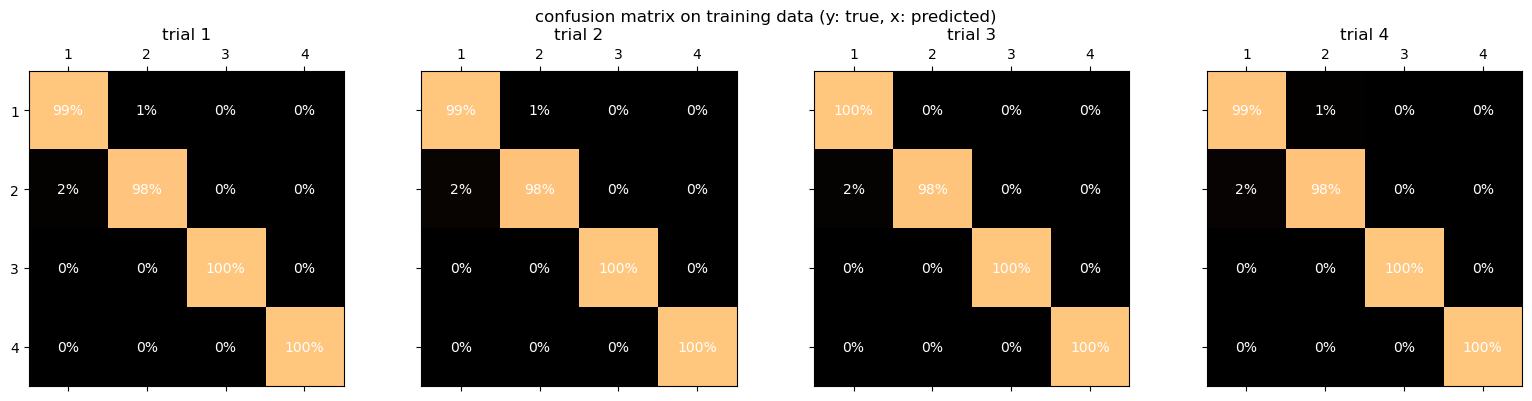

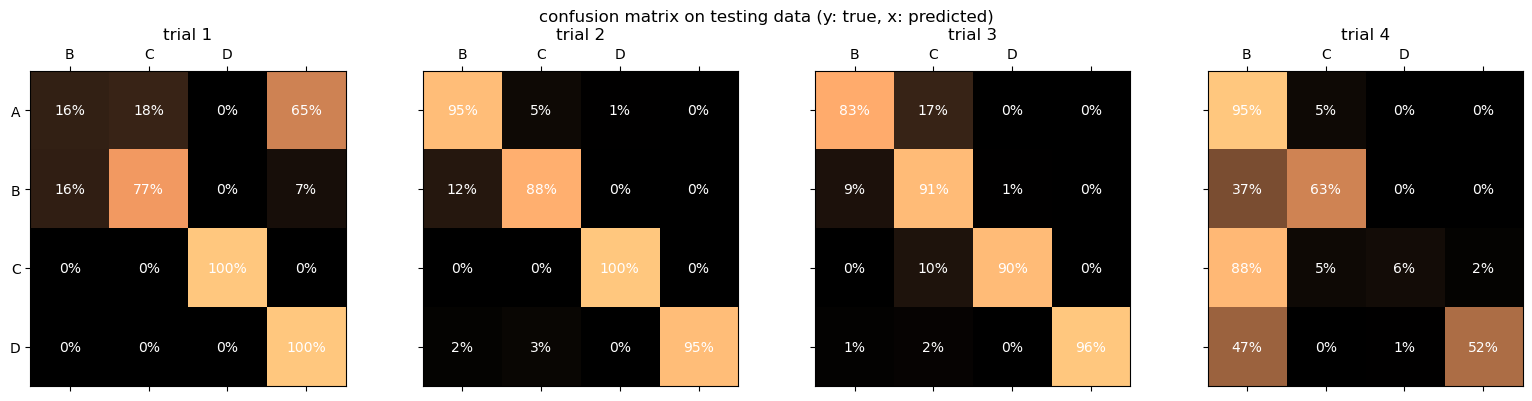

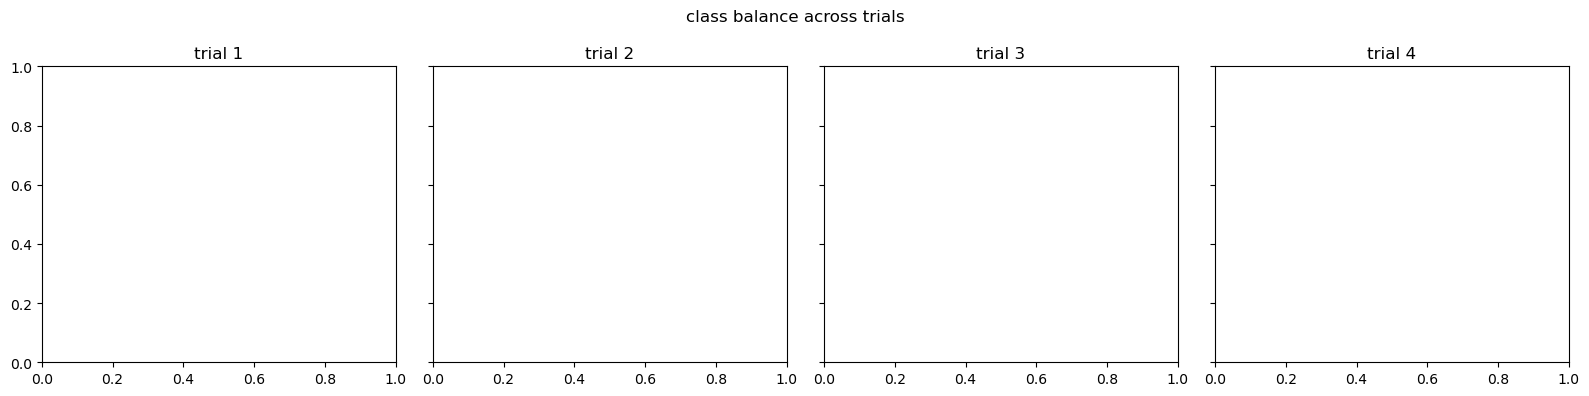

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

CMAP = 'copper'

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharex=True, sharey=True)
fig.suptitle('confusion matrix on training data (y: true, x: predicted)')
for i in range(4):
    cfm = cfms[i][0]
    axs[i].set_title(f'trial {i+1}')
    axs[i].matshow(cfms[i][0], cmap=CMAP)
    axs[i].set_yticklabels(range(5))
    axs[i].set_xticklabels(range(5))
    for a in range(4):
        for b in range(4):
            axs[i].text(b, a, f'{cfm[a, b]:.0%}', va='center', ha='center', color='w')
plt.tight_layout()

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharex=True, sharey=True)
fig.suptitle('confusion matrix on testing data (y: true, x: predicted)')
for i in range(4):
    cfm = cfms[i][1] / cfms[i][1].sum(axis=1, keepdims=True)
    axs[i].matshow(cfm, cmap=CMAP)
    axs[i].set_yticks(np.arange(0.0, 4.0, 1.0), CHARS)
    # axs[i].set_yticklabels(CHARS)
    axs[i].set_xticklabels(CHARS)
    for a in range(4):
        for b in range(4):
            axs[i].text(b, a, f'{cfm[a, b]:.0%}', va='center', ha='center', color='w')
    axs[i].set_title(f'trial {i+1}')
plt.tight_layout()

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharex=True, sharey=True)
fig.suptitle('class balance across trials')
for i in range(4):
    axs[i].set_title(f'trial {i+1}')
plt.tight_layout()

## training on all data

In [5]:
wi_pipeline, wi_tracc, wi_teacc, wi_cfms = train_linear_all_trials(DATA_FOLDER, CHARS, FIDXS, silent=True)

Train accuracy: 99.52%
Test accuracy: 99.13% 98.50% 93.61% 97.46% 
on all testing data: 98.23%


In [7]:
transform = tonic.transforms.ToImage(sensor_size=(32, 24, 2,))
train_data = []
test_data = []
train_labels = []
test_labels = []
train_trials = []
test_trials = []
for class_idx, ch in enumerate(CHARS):
    for fi in FIDXS:
        path = f'{DATA_FOLDER}/{ch}{fi}.npy'
        d = np.load(path, allow_pickle=True)
        # filter (>1k events), transform to image, flatten
        d = d[[e.shape[0] >= 1_000 for e in d]]
        d = np.array([transform(img) for img in d]).reshape(-1, 1536)

        # random 80/20 split
        train_len = int(d.shape[0] * 0.8)
        test_len = d.shape[0] - train_len
        shuffled_idxs = np.random.permutation(d.shape[0])
        train_data.append(d[shuffled_idxs[:train_len]])
        test_data.append(d[shuffled_idxs[train_len:]])

        train_labels += [class_idx] * train_len
        test_labels += [class_idx] * test_len
        train_trials += [fi] * train_len
        test_trials += [fi] * test_len
train_data = np.concatenate(train_data)
test_data = np.concatenate(test_data)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
train_trials = np.array(train_trials)
test_trials = np.array(test_trials)

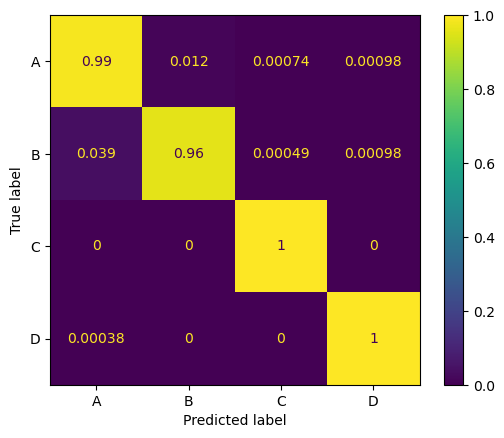

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cfm = confusion_matrix(wi_pipeline.predict(test_data), test_labels, normalize='true')
disp = ConfusionMatrixDisplay(cfm, display_labels=CHARS)
disp.plot()
plt.show()

# Old way (non-modular)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tonic
import warnings

/home/stevenabreu/miniconda3/envs/dvsflow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_folder = '../data/quat_1ms_comp/'
chars = list("ABCD")
fidxs = list(range(1, 5))
paths = sorted([f'{data_folder}/{c}{fi}.npy' for c in chars for fi in fidxs])

## checks

check potential dataset class imbalance

In [5]:
per_particle = {ch: (0, 0) for ch in chars}
for ch in chars:
    for fi in fidxs:
        path = f'{data_folder}/{ch}{fi}.npy'
        data = np.load(path, allow_pickle=True)
        over1k = [e for e in data if e.shape[0] >= 1000]
        per_particle[ch] = (per_particle[ch][0] + len(over1k), per_particle[ch][1] + data.shape[0])
        print(f'{ch}{fi}: {data.shape[0]/1000:4.1f}k -> {len(over1k)/1000:5.2f}k '
              f'({len(over1k)/data.shape[0]:5.1%})', end=', ')
    print()
for ch, (n_over, n_total) in per_particle.items():
    print(f'{ch}: {n_total/1000:5.1f}k -> {n_over/1000:5.1f}k ({n_over/n_total:5.1%})')

A1: 59.0k ->  0.66k ( 1.1%), A2: 56.3k ->  3.68k ( 6.5%), A3: 60.7k ->  2.57k ( 4.2%), A4: 59.3k -> 13.52k (22.8%), 
B1: 57.7k ->  1.50k ( 2.6%), B2: 56.8k ->  2.43k ( 4.3%), B3: 58.4k ->  2.13k ( 3.6%), B4: 59.3k ->  3.93k ( 6.6%), 
C1: 57.4k -> 22.26k (38.8%), C2: 55.7k -> 20.16k (36.2%), C3: 59.7k ->  0.03k ( 0.0%), C4: 59.1k ->  0.03k ( 0.1%), 
D1: 56.4k -> 11.61k (20.6%), D2: 61.7k ->  0.66k ( 1.1%), D3: 59.3k ->  0.82k ( 1.4%), D4: 60.0k ->  0.24k ( 0.4%), 
A: 235.3k ->  20.4k ( 8.7%)
B: 232.1k ->  10.0k ( 4.3%)
C: 231.9k ->  42.5k (18.3%)
D: 237.4k ->  13.3k ( 5.6%)


strong imbalance!

## load data

In [7]:
data = []
label = []
trial = []
for class_idx, ch in enumerate(chars):
    for fi in fidxs:
        path = f'{data_folder}/{ch}{fi}.npy'
        d = np.load(path, allow_pickle=True)
        d = d[[e.shape[0] >= 1_000 for e in d]]
        data.append(d)
        label.append([class_idx] * len(d))
        trial.append([fi] * len(d))
data = np.concatenate(data)
label = np.concatenate(label)
trial = np.concatenate(trial)

In [8]:
transform = tonic.transforms.ToImage(sensor_size=(32, 24, 2,))
data = np.array([transform(img) for img in data])

In [9]:
data.shape

(86220, 2, 24, 32)

## train linear models

In [10]:
data = data.reshape(data.shape[0], -1) # 2, 24, 32 -> 1536
data.shape

(86220, 1536)

### generalization to new trial

Train on three trials, test on the fourth one

In [28]:
# train linear classifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning

tracc = []
teacc = []
cfms = []

for test_trial in range(1, 5):
    # train test split
    train_idxs = trial != test_trial
    test_idxs = trial == test_trial
    train_data = data[train_idxs]
    train_labels = label[train_idxs]
    train_trials = trial[train_idxs]
    test_data = data[test_idxs]
    test_labels = label[test_idxs]
    test_trials = trial[test_idxs]

    # log
    print(f'Testing on trial {test_trial}, training on all others')
    print(f'  Train: {train_data.shape[0]/1000:3.0f}k, Test: {test_data.shape[0]/1000:3.0f}k')

    # train pipeline: standard scaler + logistic regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', LogisticRegression(max_iter=1000))
    ])
    # train and handle convergence warnings
    warnings.simplefilter('ignore', ConvergenceWarning)
    pipeline.fit(train_data, train_labels)
    warnings.simplefilter('default', ConvergenceWarning)

    tracc.append(pipeline.score(train_data, train_labels))
    teacc.append(pipeline.score(test_data, test_labels))
    cfms.append((
        confusion_matrix(pipeline.predict(train_data), train_labels),
        confusion_matrix(pipeline.predict(test_data), test_labels)
    ))
    print(f'Train accuracy: {tracc[-1]:.2%}')
    print(f'Test accuracy:  {teacc[-1]:.2%}')
    print()
tracc = np.array(tracc)
teacc = np.array(teacc)

Testing on trial 1, training on all others
  Train:  50k, Test:  36k
[warning] didn't converge


AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [15]:
tracc = np.array(tracc)
teacc = np.array(teacc)
print(f'training: {tracc.mean():.2%} +- {tracc.std():.2%}')
print(f'testing:  {teacc.mean():.2%} +- {teacc.std():.2%}')

training: 99.62% +- 0.10%
testing:  90.34% +- 5.43%


**Old results**:

Testing on trial 1, training on all others
  Train:  50k, Test:  36k
Train accuracy: 99.53%
Test accuracy:  92.59%

Testing on trial 2, training on all others
  Train:  59k, Test:  27k
Train accuracy: 99.51%
Test accuracy:  97.95%

Testing on trial 3, training on all others
  Train:  81k, Test:   6k
Train accuracy: 99.73%
Test accuracy:  87.23%

Testing on trial 4, training on all others
  Train:  69k, Test:  18k
Train accuracy: 99.71%
Test accuracy:  83.60%

### generalization within trials

train on the first 80% of each trial, test on the remaining 20% of each trial

In [16]:
transform = tonic.transforms.ToImage(sensor_size=(32, 24, 2,))
train_data = []
test_data = []
train_labels = []
test_labels = []
train_trials = []
test_trials = []
for class_idx, ch in enumerate(chars):
    for fi in fidxs:
        path = f'{data_folder}/{ch}{fi}.npy'
        d = np.load(path, allow_pickle=True)
        # filter (>1k events), transform to image, flatten
        d = d[[e.shape[0] >= 1_000 for e in d]]
        d = np.array([transform(img) for img in d]).reshape(-1, 1536)

        # random 80/20 split
        train_len = d.shape[0] * 4 // 5
        test_len = d.shape[0] - train_len
        shuffled_idxs = np.random.permutation(d.shape[0])
        train_data.append(d[shuffled_idxs[:train_len]])
        test_data.append(d[shuffled_idxs[train_len:]])

        train_labels += [class_idx] * train_len
        test_labels += [class_idx] * test_len
        train_trials += [fi] * train_len
        test_trials += [fi] * test_len
train_data = np.concatenate(train_data)
test_data = np.concatenate(test_data)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
train_trials = np.array(train_trials)
test_trials = np.array(test_trials)

In [17]:
# train linear classifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# train pipeline: standard scaler + logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression(max_iter=1000))
])
pipeline.fit(train_data, train_labels)

tracc = pipeline.score(train_data, train_labels)
print(f'Train accuracy: {tracc:.2%}')

print(f'Test accuracy: ', end='')
teacc = {}
for te_idx in range(1, 5):
    te_mask = test_trials == te_idx
    teacc[te_idx] = pipeline.score(test_data[te_mask], test_labels[te_mask])
    print(f'{teacc[te_idx]:.2%}', end=' ')
print()

/home/stevenabreu/miniconda3/envs/dvsflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy: 99.53%
Test accuracy: 98.95% 98.92% 94.15% 97.12% 


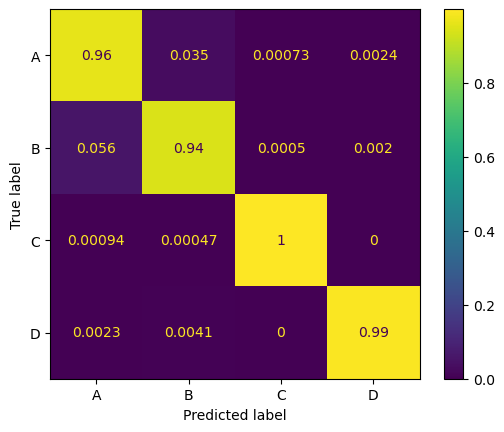

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_pred = pipeline.predict(test_data)
cfm = confusion_matrix(test_labels, test_pred, normalize='true')
disp = ConfusionMatrixDisplay(cfm, display_labels=chars)
disp.plot()
plt.show()